In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# !cd /content/drive/MyDrive/olive_review

In [1]:
!pip install transformers

  Using cached transformers-4.26.1-py3-none-any.whl (6.3 MB)
     ---------------------------------------- 3.3/3.3 MB 14.0 MB/s eta 0:00:00
  Using cached PyYAML-6.0-cp37-cp37m-win_amd64.whl (153 kB)
     -------------------------------------- 268.0/268.0 kB 8.3 MB/s eta 0:00:00
  Using cached huggingface_hub-0.12.1-py3-none-any.whl (190 kB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)


In [6]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [19]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification, BertModel, AutoTokenizer, TFBertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

In [8]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  

config = BertConfig.from_pretrained("bert-base-uncased",output_hidden_states=False) # dropout=0.2, attention_dropout=0.2
bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [27]:
reviews = pd.read_csv('E:/olive_young/Review_NLP/reviews_final.csv')
reviews.shape

(15567, 4)

In [28]:
# 데이터 분리
X = reviews['reviews']
y = reviews['key_sent']

# X2 = reviews[reviews.key_sent == 1].reviews
# y2 = reviews[reviews.key_sent == 1].sentiment

In [32]:
sentences = X

In [33]:
input_ids=[]
attention_masks=[]

for sent in tqdm(sentences):
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =260,pad_to_max_length = True,
                                        return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
target = np.array(pd.get_dummies(y))

  0%|                                                                                        | 0/15567 [00:00<?, ?it/s]C:\Users\aaa\anaconda3\envs\tfgpu3\lib\site-packages\transformers\tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████████████████████████████████████████████████████████████████████| 15567/15567 [00:07<00:00, 2199.22it/s]


In [13]:
bert_tokenizer.convert_ids_to_tokens(101)

'[CLS]'

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, train_mask, test_mask = train_test_split(input_ids, target, attention_masks, test_size=0.2)

In [35]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 0
Non-trainable params: 109,482,240
_________________________________________________________________


In [36]:
def create_model(model_):
    input_ids = tf.keras.Input(shape=(260,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(260,),dtype='int32')
    
    output = model_(input_ids,attention_masks)
    output = output[0]    
    
    output = output[:,0,:] 
    
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(2,activation='softmax')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    
    
    for layer in model.layers[:3]:
        layer.trainable = False
    return model

model = create_model(bert_model)
model.summary()  

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 260)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 260)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 768)          0           tf_bert_model[1][0]        

In [37]:
def model_compile(model):
    
    adam = Adam(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
    
    return model

In [38]:
model_compile(model)

In [39]:
early_stopping = EarlyStopping(
    monitor = "val_accuracy", 
    min_delta = 1e-3,
    patience = 5)

In [40]:
model_path = 'E:/olive_young/Review_NLP/models/bert_model.h5'

model_checkpoint = ModelCheckpoint(
    filepath = model_path,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True, 
    verbose = 1
)

In [41]:
history = model.fit([X_train,train_mask],y_train,batch_size=32,epochs=50,validation_data=([X_test,test_mask],y_test),
                   callbacks=[early_stopping, model_checkpoint], shuffle=True)

Epoch 1/50
390/390 [==============================] - 476s 1s/step - loss: 0.6538 - accuracy: 0.6241 - val_loss: 0.6387 - val_accuracy: 0.6101

Epoch 00001: val_accuracy improved from -inf to 0.61015, saving model to E:/olive_young/Review_NLP/models\bert_model.h5
Epoch 2/50
390/390 [==============================] - 466s 1s/step - loss: 0.6335 - accuracy: 0.6192 - val_loss: 0.6167 - val_accuracy: 0.6551

Epoch 00002: val_accuracy improved from 0.61015 to 0.65511, saving model to E:/olive_young/Review_NLP/models\bert_model.h5
Epoch 3/50
390/390 [==============================] - 468s 1s/step - loss: 0.6284 - accuracy: 0.6252 - val_loss: 0.6216 - val_accuracy: 0.6339

Epoch 00003: val_accuracy did not improve from 0.65511
Epoch 4/50
390/390 [==============================] - 470s 1s/step - loss: 0.6229 - accuracy: 0.6470 - val_loss: 0.6118 - val_accuracy: 0.6484

Epoch 00004: val_accuracy did not improve from 0.65511
Epoch 5/50
390/390 [==============================] - 470s 1s/step - lo

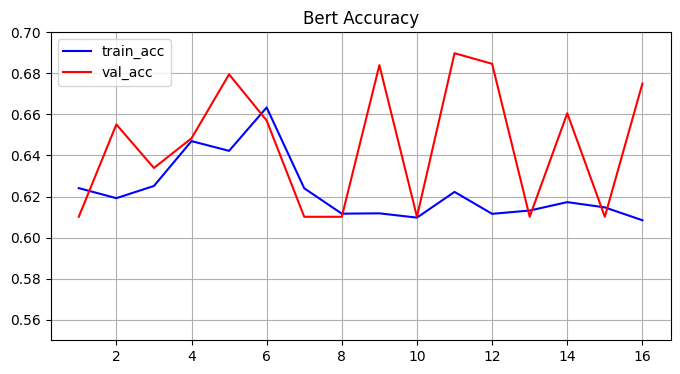

In [69]:
bert_acc = history.history['accuracy']
bert_val_acc = history.history['val_accuracy']

epochs = range(1, len(bert_acc)+1)
plt.figure(figsize=(8, 4))
plt.title('Bert Accuracy')
plt.plot(epochs, bert_acc, 'b', label='train_acc')
plt.plot(epochs, bert_val_acc, 'r', label='val_acc')
plt.grid()
plt.ylim(0.55, 0.70)
plt.legend()
plt.savefig('E:/olive_young/Review_NLP/metric/Bert_Accuracy.png')
plt.show()

In [56]:
bert_best_model = tf.keras.models.load_model(model_path,
                                                  custom_objects={'TFBertModel': TFBertModel})

In [63]:
bert_test_res = bert_best_model.evaluate([X_test,test_mask], y_test)
bert_test_res

98/98 [==============================] - 86s 854ms/step - loss: 0.5877 - accuracy: 0.6898


[0.5877459645271301, 0.6897880434989929]

In [60]:
predicted_value = bert_best_model.predict([X_test,test_mask])
predicted_label = np.argmax(predicted_value, axis = 1)

In [97]:
new_y_test = []
for value in y_test:
    if value[0] == 0:
        new_y_test.append(1)
    else:
        new_y_test.append(0)

In [98]:
CL_REPORT_FILE = 'E:/olive_young/Review_NLP/metric/cl_report_bert_model.csv'

cl_report = classification_report(new_y_test, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
cl_report_df.to_csv(CL_REPORT_FILE)
print(cl_report_df)

              precision  recall  f1-score  support
0                 0.711   0.827     0.765  1900.00
1                 0.637   0.474     0.544  1214.00
accuracy          0.690   0.690     0.690     0.69
macro avg         0.674   0.651     0.654  3114.00
weighted avg      0.682   0.690     0.679  3114.00


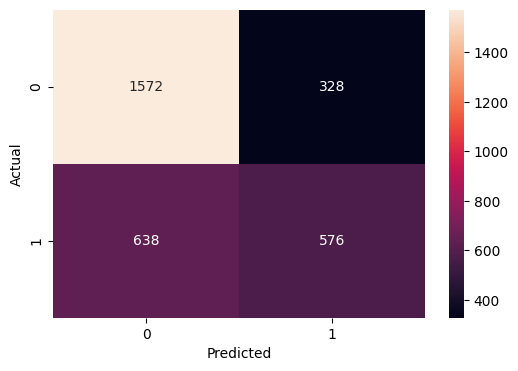

In [109]:
# 이미지 파일 저장정보
FIGURE_FILE = 'E:/olive_young/Review_NLP/figure/cf_matrix_bert_model.png'

cf_matrix = confusion_matrix(new_y_test, predicted_label)
fig, ax = plt.subplots(figsize = (6,4))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(FIGURE_FILE)
plt.show()

In [101]:
# Multi-class Classification의 대중적인 평가 지표 모두 확인
accuracy_score_v = round(accuracy_score(new_y_test, predicted_label), 2) # Accuracy
precision_score_v = round(precision_score(new_y_test, predicted_label, average="weighted"), 2) # Precision
recall_score_v = round(recall_score(new_y_test, predicted_label, average="weighted"), 2) # Recall
f1_score_v = round(f1_score(new_y_test, predicted_label, average="weighted"), 2) # F1 Score
roc_auc_score_v = round(roc_auc_score(new_y_test, predicted_label, average="weighted", multi_class="ovr"), 2) # ROC AUC Score
cohen_kappa_score_v = round(cohen_kappa_score(new_y_test, predicted_label), 2) # Cohen's Kappa Score
matthews_corrcoef_v = round(matthews_corrcoef(new_y_test, predicted_label), 2) # Matthew's Correlation Coefficient
log_loss_v = round(log_loss(new_y_test, new_y_test), 2) # Log Loss

In [106]:
METRIC_FILE = 'E:/olive_young/Review_NLP/metric/bert_model_metric.csv'
# 평가지표 결과 저장
metric_total = pd.DataFrame({
    'PLM': "bert",
    'Optimizer': "adam",
    'Accuracy': accuracy_score_v,
    'Precision': precision_score_v,
    'Recall': recall_score_v,
    'F1_score': f1_score_v,
    'ROC_AUC_score': roc_auc_score_v,
    'Cohen_kappa_coef': cohen_kappa_score_v,
    'Matthews_corrcoef': matthews_corrcoef_v,
    'Log_loss': log_loss_v},
    index = ['-']
    )  

In [107]:
metric_total.to_csv(METRIC_FILE)

In [108]:
print(metric_total)

    PLM Optimizer  Accuracy  Precision  Recall  F1_score  ROC_AUC_score  \
-  bert      adam      0.69       0.68    0.69      0.68           0.65   

   Cohen_kappa_coef  Matthews_corrcoef  Log_loss  
-              0.32               0.32       0.0  
